In [1]:
# AIR: use the mdanalysis environment

import pandas as pd
import numpy as np
import deeptime as dt
import matplotlib.pyplot as plt
import hexagonal_grid
from tqdm import tqdm
import os

In [2]:
%connect_info
%cd {os.environ['HOME']}/Sync/work_in_progress/sh2-som

{
  "shell_port": 9002,
  "iopub_port": 9004,
  "stdin_port": 9003,
  "control_port": 9001,
  "hb_port": 9000,
  "ip": "127.0.0.1",
  "key": "3caf9e10-7941-403f-9dce-eac45c1790a3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-60772XQihOjwX5ld2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
/Users/toni/Sync/work_in_progress/sh2-som


In [3]:
d=pd.read_table("SOM.neuron.classification.dat.xz")
d["RFrame"]=d.groupby(['Replica']).cumcount()
d["State"]=d["Neuron.classif"]-1

# Fix: RFrame is the replica's frame
#      State is the 0-based neuron assignment

In [4]:
# Split by replica. Make each replica's state list a list element.
# traj_list is therefore a list of numpy arrays holding 0-based states

dg=d.groupby("Replica")
traj_list=[dg.get_group(x).State.to_numpy() for x in dg.groups]

In [5]:
models = []
#lagtimes = [1,10,20,30,60,100,200,300]
lagtimes = np.arange(1, 400, 20)
for lagtime in tqdm(lagtimes):
    counts = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(traj_list)
    #mod=dt.markov.msm.BayesianMSM(n_samples=50).fit(counts,ignore_counting_mode=True).fetch()
    mod=dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(counts)
    models.append(mod)
    #models.append()


100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Text(0, 0.5, 'timescale (steps)')

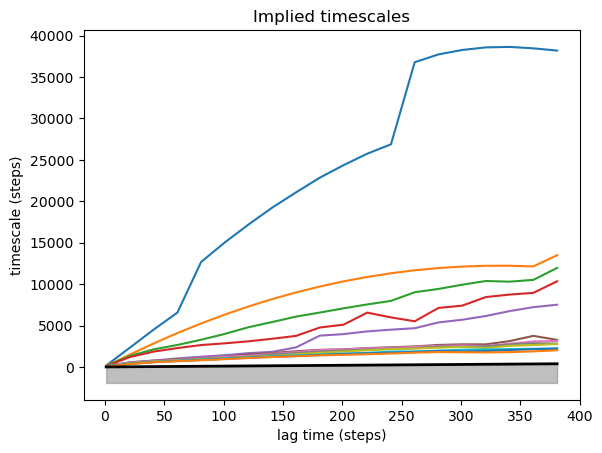

In [6]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=12, ax=ax)
#ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')



In [9]:
# Bayesian estimation (slow)

estimator = dt.markov.msm.BayesianMSM(
    n_samples=100,
    n_steps=10,
    reversible=True,
    stationary_distribution_constraint=None
)
ts_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1, count_mode="effective"
)
counts_effective = ts_estimator.fit(traj_list).fetch_model()

AttributeError: module 'deeptime' has no attribute 'counts_estimator'

# PCCA

In [ ]:
hgrid = hexagonal_grid.hexagonal_grid(20,20)

In [ ]:
chosen_model = hexagonal_grid.index_of_closest(lagtimes, 250)
chosen_model

12

In [ ]:
pccamodel = models[chosen_model]
n_macro=10
pcca = pccamodel.pcca(n_metastable_sets=n_macro)


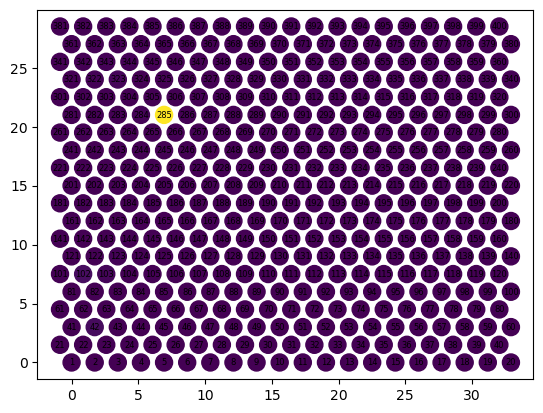

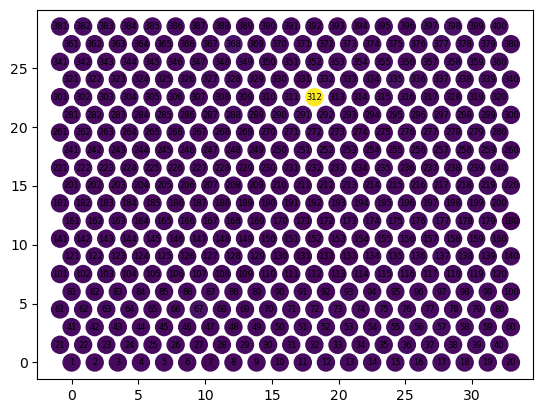

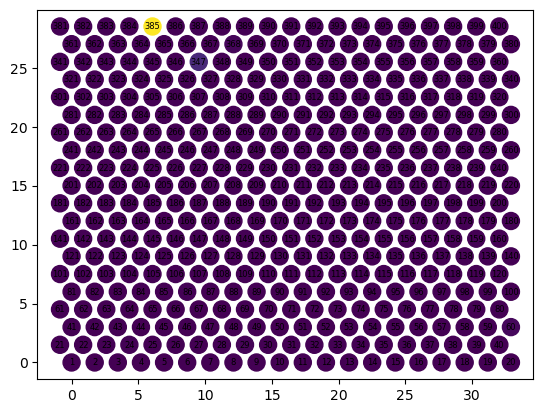

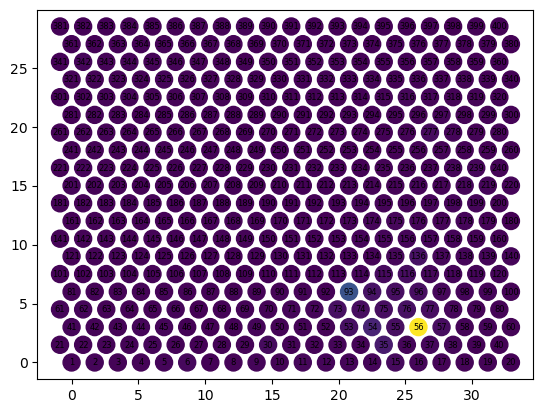

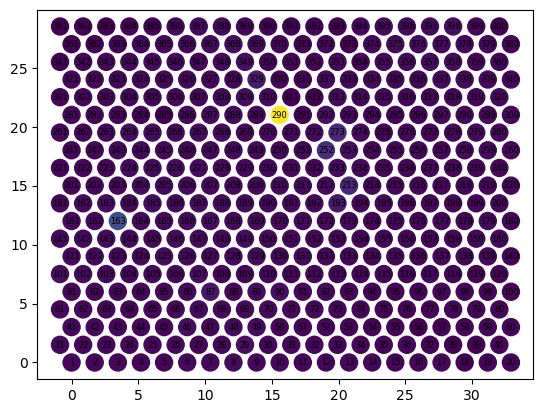

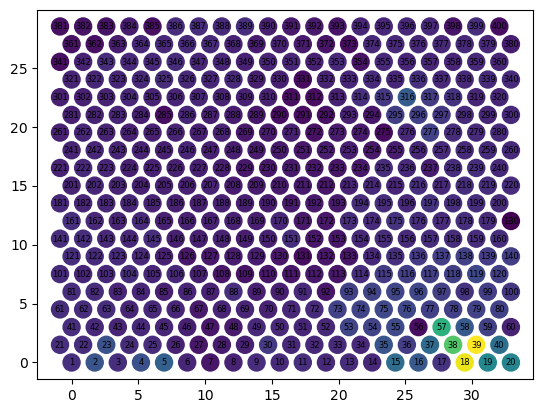

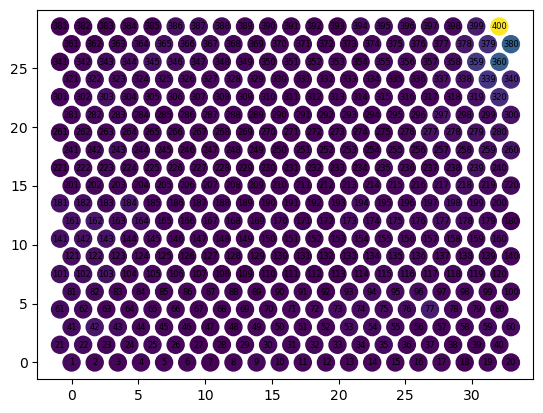

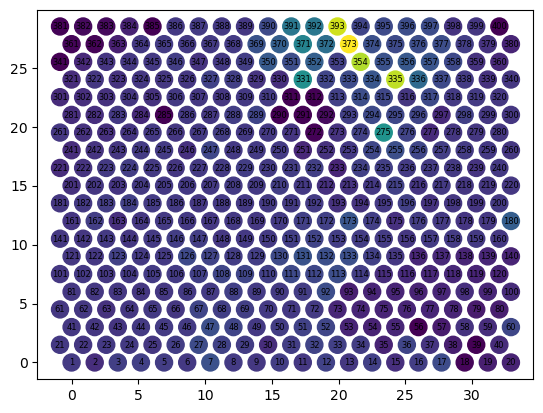

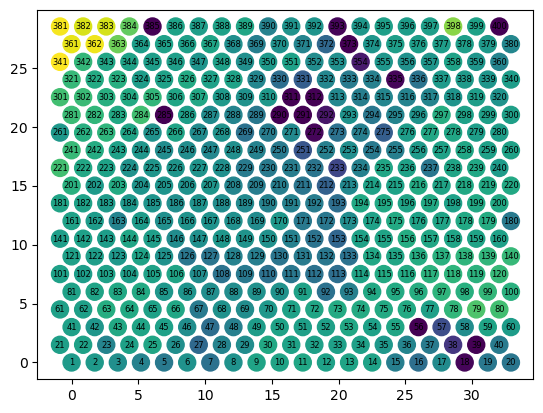

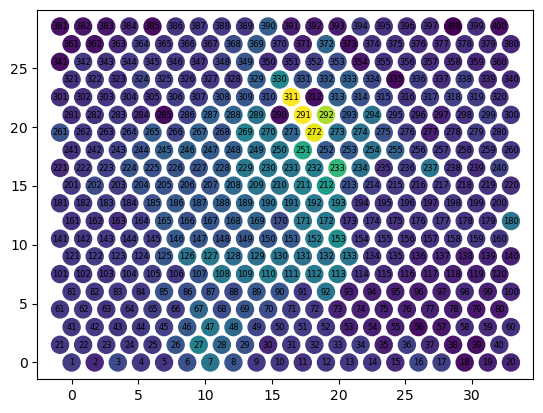

In [ ]:
for m in range(n_macro):
    hexagonal_grid.state_plot(hgrid, pcca.memberships[:,m])
    plt.show()

[0.00285125 0.03302834 0.00775007 0.01781949 0.02231293 0.09003874
 0.03335259 0.14194419 0.32710767 0.32379473]


Text(0.5, 0, 'Macrostate')

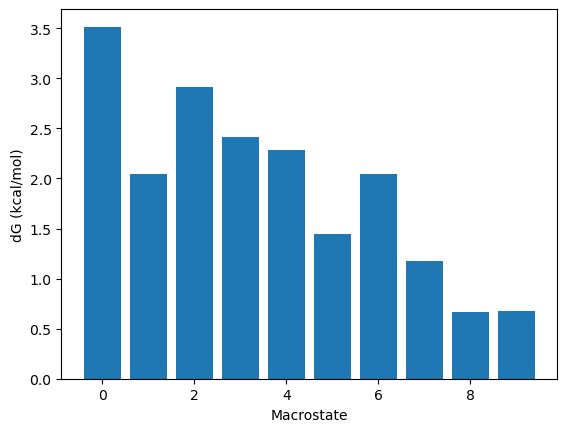

In [ ]:
print(pcca.coarse_grained_stationary_probability)
plt.bar(range(n_macro),
        -.6*np.log(pcca.coarse_grained_stationary_probability))
plt.ylabel("dG (kcal/mol)")
plt.xlabel("Macrostate")

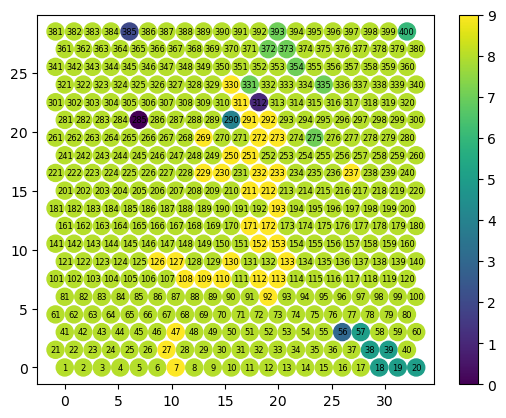

In [ ]:
hexagonal_grid.state_plot(hgrid, pcca.assignments)
plt.colorbar()